In [1]:
import streamlit as st
from PIL import Image
from skimage import data
from skimage import transform
from skimage.feature import blob_log
from matplotlib import pyplot as plt
from skyfield.api import Star, Topos, load
from skyfield.data import hipparcos
import numpy as np
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
import os
import time
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)

In [2]:
stardict = {}
with open('common_stars.txt') as f:
    lines = f.readlines()
    for line in lines:
        entry = line.strip().split("\t")
        stardict[int(entry[1])] = entry[0]
        stardict[int(entry[3])] = entry[2]

df = df[df['magnitude'] <= 4]
print('After filtering, there are {} stars'.format(len(df)))
bright_stars = Star.from_dataframe(df)

planets = load('de421.bsp')
earth = planets['earth']
ts = load.timescale()


After filtering, there are 519 stars


In [3]:
def fish2cylindrical(x,y, f, zoom):
#     f = 10.5/23.6*W
    long = x/f/zoom
    lat = np.arctan(y/f/zoom)
    xx = np.cos(lat) * np.sin(long)
    yy = np.sin(lat)
    phi = np.arctan2(yy,xx)
    theta = np.arcsin(np.sqrt(xx*xx + yy*yy))
    mag = 2*f*np.sin(theta/2)
#     return mag, phi
    return mag*np.cos(phi), mag*np.sin(phi)

def cylindrical2fish(x,y, f, zoom):
#     f = 10.5/23.6*W
    theta = np.arcsin(np.sqrt(x*x + y*y) / (2*f))
    mag = np.sin(theta * 2) # = np.sqrt(xx*xx+yy*yy)
    phi = np.arctan2(y,x)
    xx = mag*np.cos(phi)
    yy = mag*np.sin(phi)
    lat = np.arcsin(yy)
    long = np.arcsin(xx / np.cos(lat))
    y = (f / zoom)*np.tan(lat)
    x = long * f / zoom
    return x,y

def fish2mercator(x,y, f, zoom):
#     f = 10.5/23.6*W
    long = x/f/zoom
    lat = np.arctan(np.sinh(y/f/zoom))
    xx = np.cos(lat) * np.sin(long)
    yy = np.sin(lat)
    phi = np.arctan2(yy,xx)
    theta = np.arcsin(np.sqrt(xx*xx + yy*yy))
    mag = 2*f*np.sin(theta/2)
#     return mag, theta
    return mag*np.cos(phi), mag*np.sin(phi)

def mercator2fish(x,y, f, zoom):
#     f = 10.5/23.6*W
    theta = np.arcsin(np.sqrt(x*x + y*y) / (2*f))
    mag = np.sin(theta * 2) # = np.sqrt(xx*xx+yy*yy)
    phi = np.arctan2(y,x)
    xx = mag*np.cos(phi)
    yy = mag*np.sin(phi)
    lat = np.arcsin(yy)
    long = np.arcsin(xx / np.cos(lat))
    y = (f / zoom)*np.arcsinh(np.tan(lat))
    x = long * f / zoom
    return x,y

def fish2equirectangular(x,y, f, zoom):
#     f = 10.5/23.6*W
    long = x/f/zoom
    lat = y/f/zoom
    xx = np.cos(lat) * np.sin(long)
    yy = np.sin(lat)
    phi = np.arctan2(yy,xx)
    theta = np.arcsin(np.sqrt(xx*xx + yy*yy))
    mag = 2*f*np.sin(theta/2)
#     return mag, theta
    return mag*np.cos(phi), mag*np.sin(phi)

def equirectangular2fish(x,y, f, zoom):
#     f = 10.5/23.6*W
    theta = np.arcsin(np.sqrt(x*x + y*y) / (2*f))
    mag = np.sin(theta * 2) # = np.sqrt(xx*xx+yy*yy)
    phi = np.arctan2(y,x)
    xx = mag*np.cos(phi)
    yy = mag*np.sin(phi)
    lat = np.arcsin(yy)
    long = np.arcsin(xx / np.cos(lat))
    y = lat * f / zoom
    x = long * f / zoom
    return x,y

streamlit/pic000500.dat 155


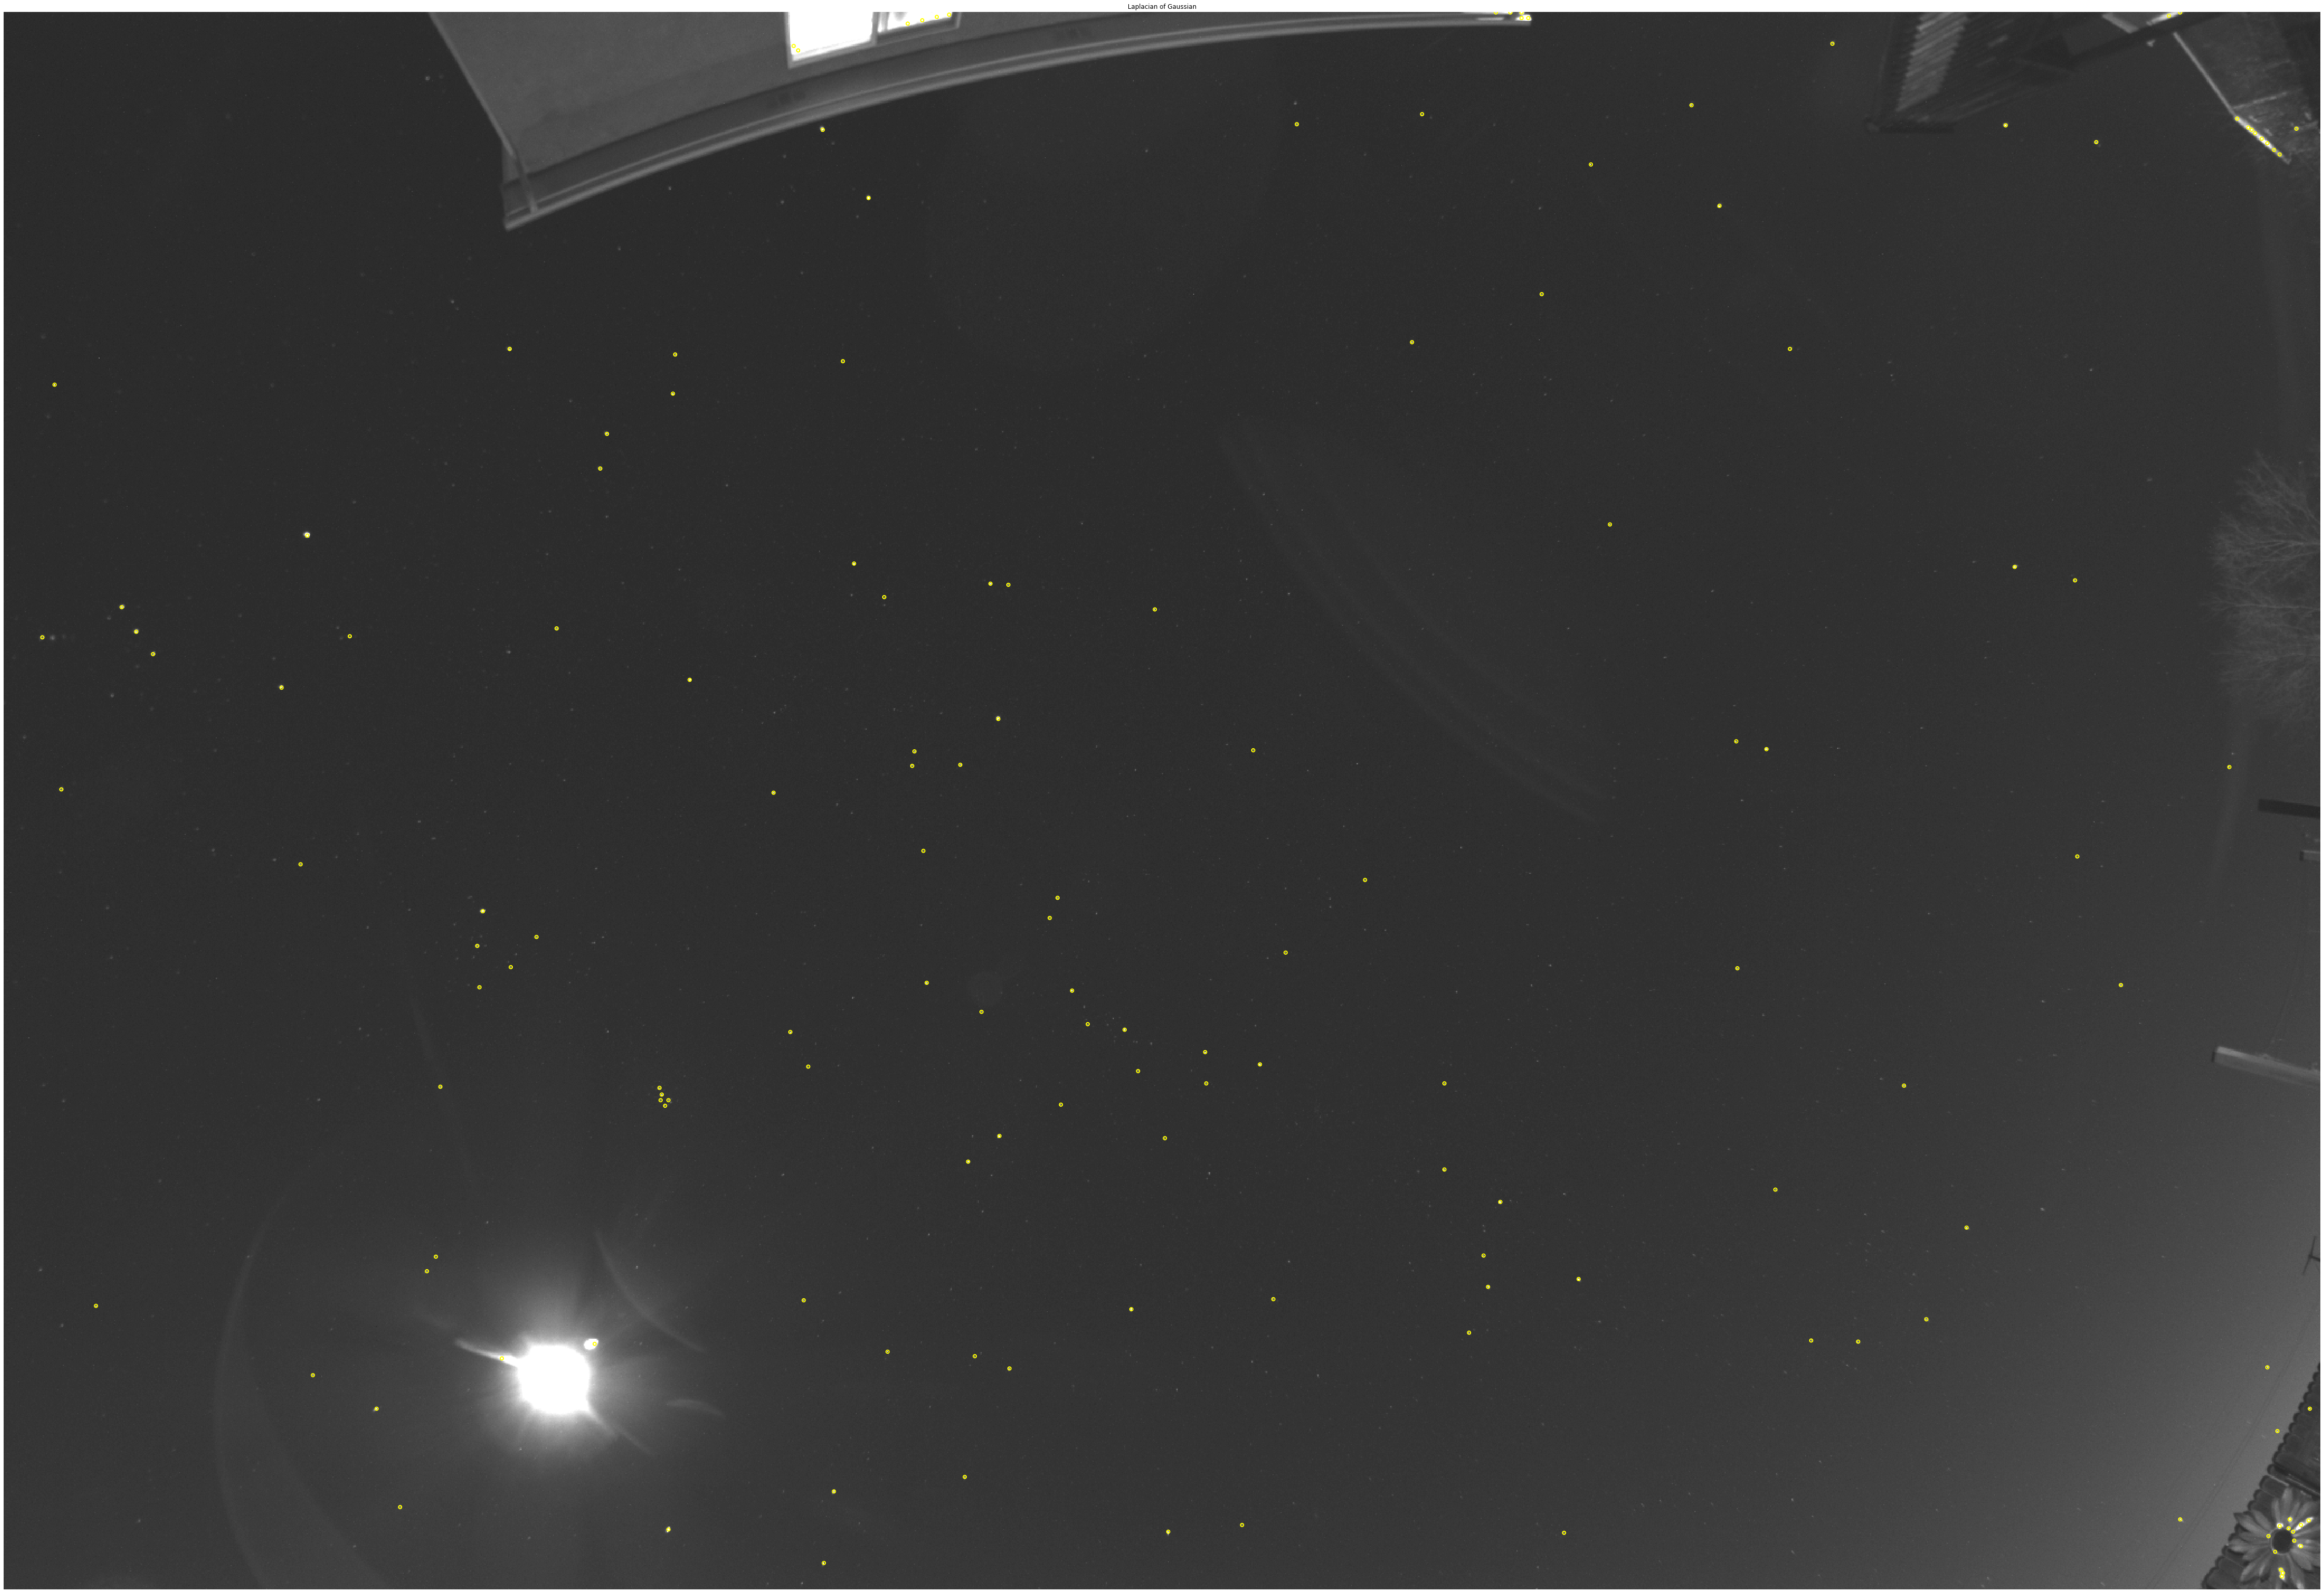

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(80, 80), sharex=True, sharey=True)
myblobs = []

thresh = 0.003

for cc in range(1):
#     fname = f"streamlit/pic{cc*10:06d}.dat"
    fname = f"streamlit/pic{500:06d}.dat"
    
    raw = np.fromfile(fname, dtype=np.float64).reshape((2822,4144))
#     print(raw.shape)

    tstamp = os.path.getmtime(fname)
#     print(tstamp)

    timestamp = datetime.fromtimestamp(tstamp)
#     print(timestamp.year)

    parray = 0.2125*raw[::2,::2] + 0.7154 * (raw[1::2,::2] + raw[::2,1::2]) / 2.0 + 0.0721 * raw[1::2,1::2]
    out = parray / np.max(parray)
    
    
    blobs_log = blob_log(out, max_sigma=120, num_sigma=5, threshold=thresh)
            
    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)
    swgain = 20
    
    blobs_log = blobs_log[np.where(blobs_log[:,2] < 3)]
    
    print(fname, len(blobs_log))
    myblobs.append(blobs_log)

    blobs_list = [blobs_log]
    colors = ['yellow']
    titles = ['Laplacian of Gaussian']
    sequence = zip(blobs_list, colors, titles)

    # ax = axes.ravel()
    # ax[1].imshow(immask, cmap='gray', interpolation='none')
    # ax[1].set_title("Mask using variance")

    for idx, (blobs, color, title) in enumerate(sequence):
        ax.set_title(title)
        if cc == 0:
            ax.imshow(out*swgain, cmap='gray', interpolation='none',vmin=0.1, vmax=0.6)
        for blob in blobs:
            y, x, r = blob
            c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
            ax.add_patch(c)
        ax.set_axis_off()


cos = earth + Topos('38.8605998 N', '104.6751112 W', elevation_m=2000)
plt.show()

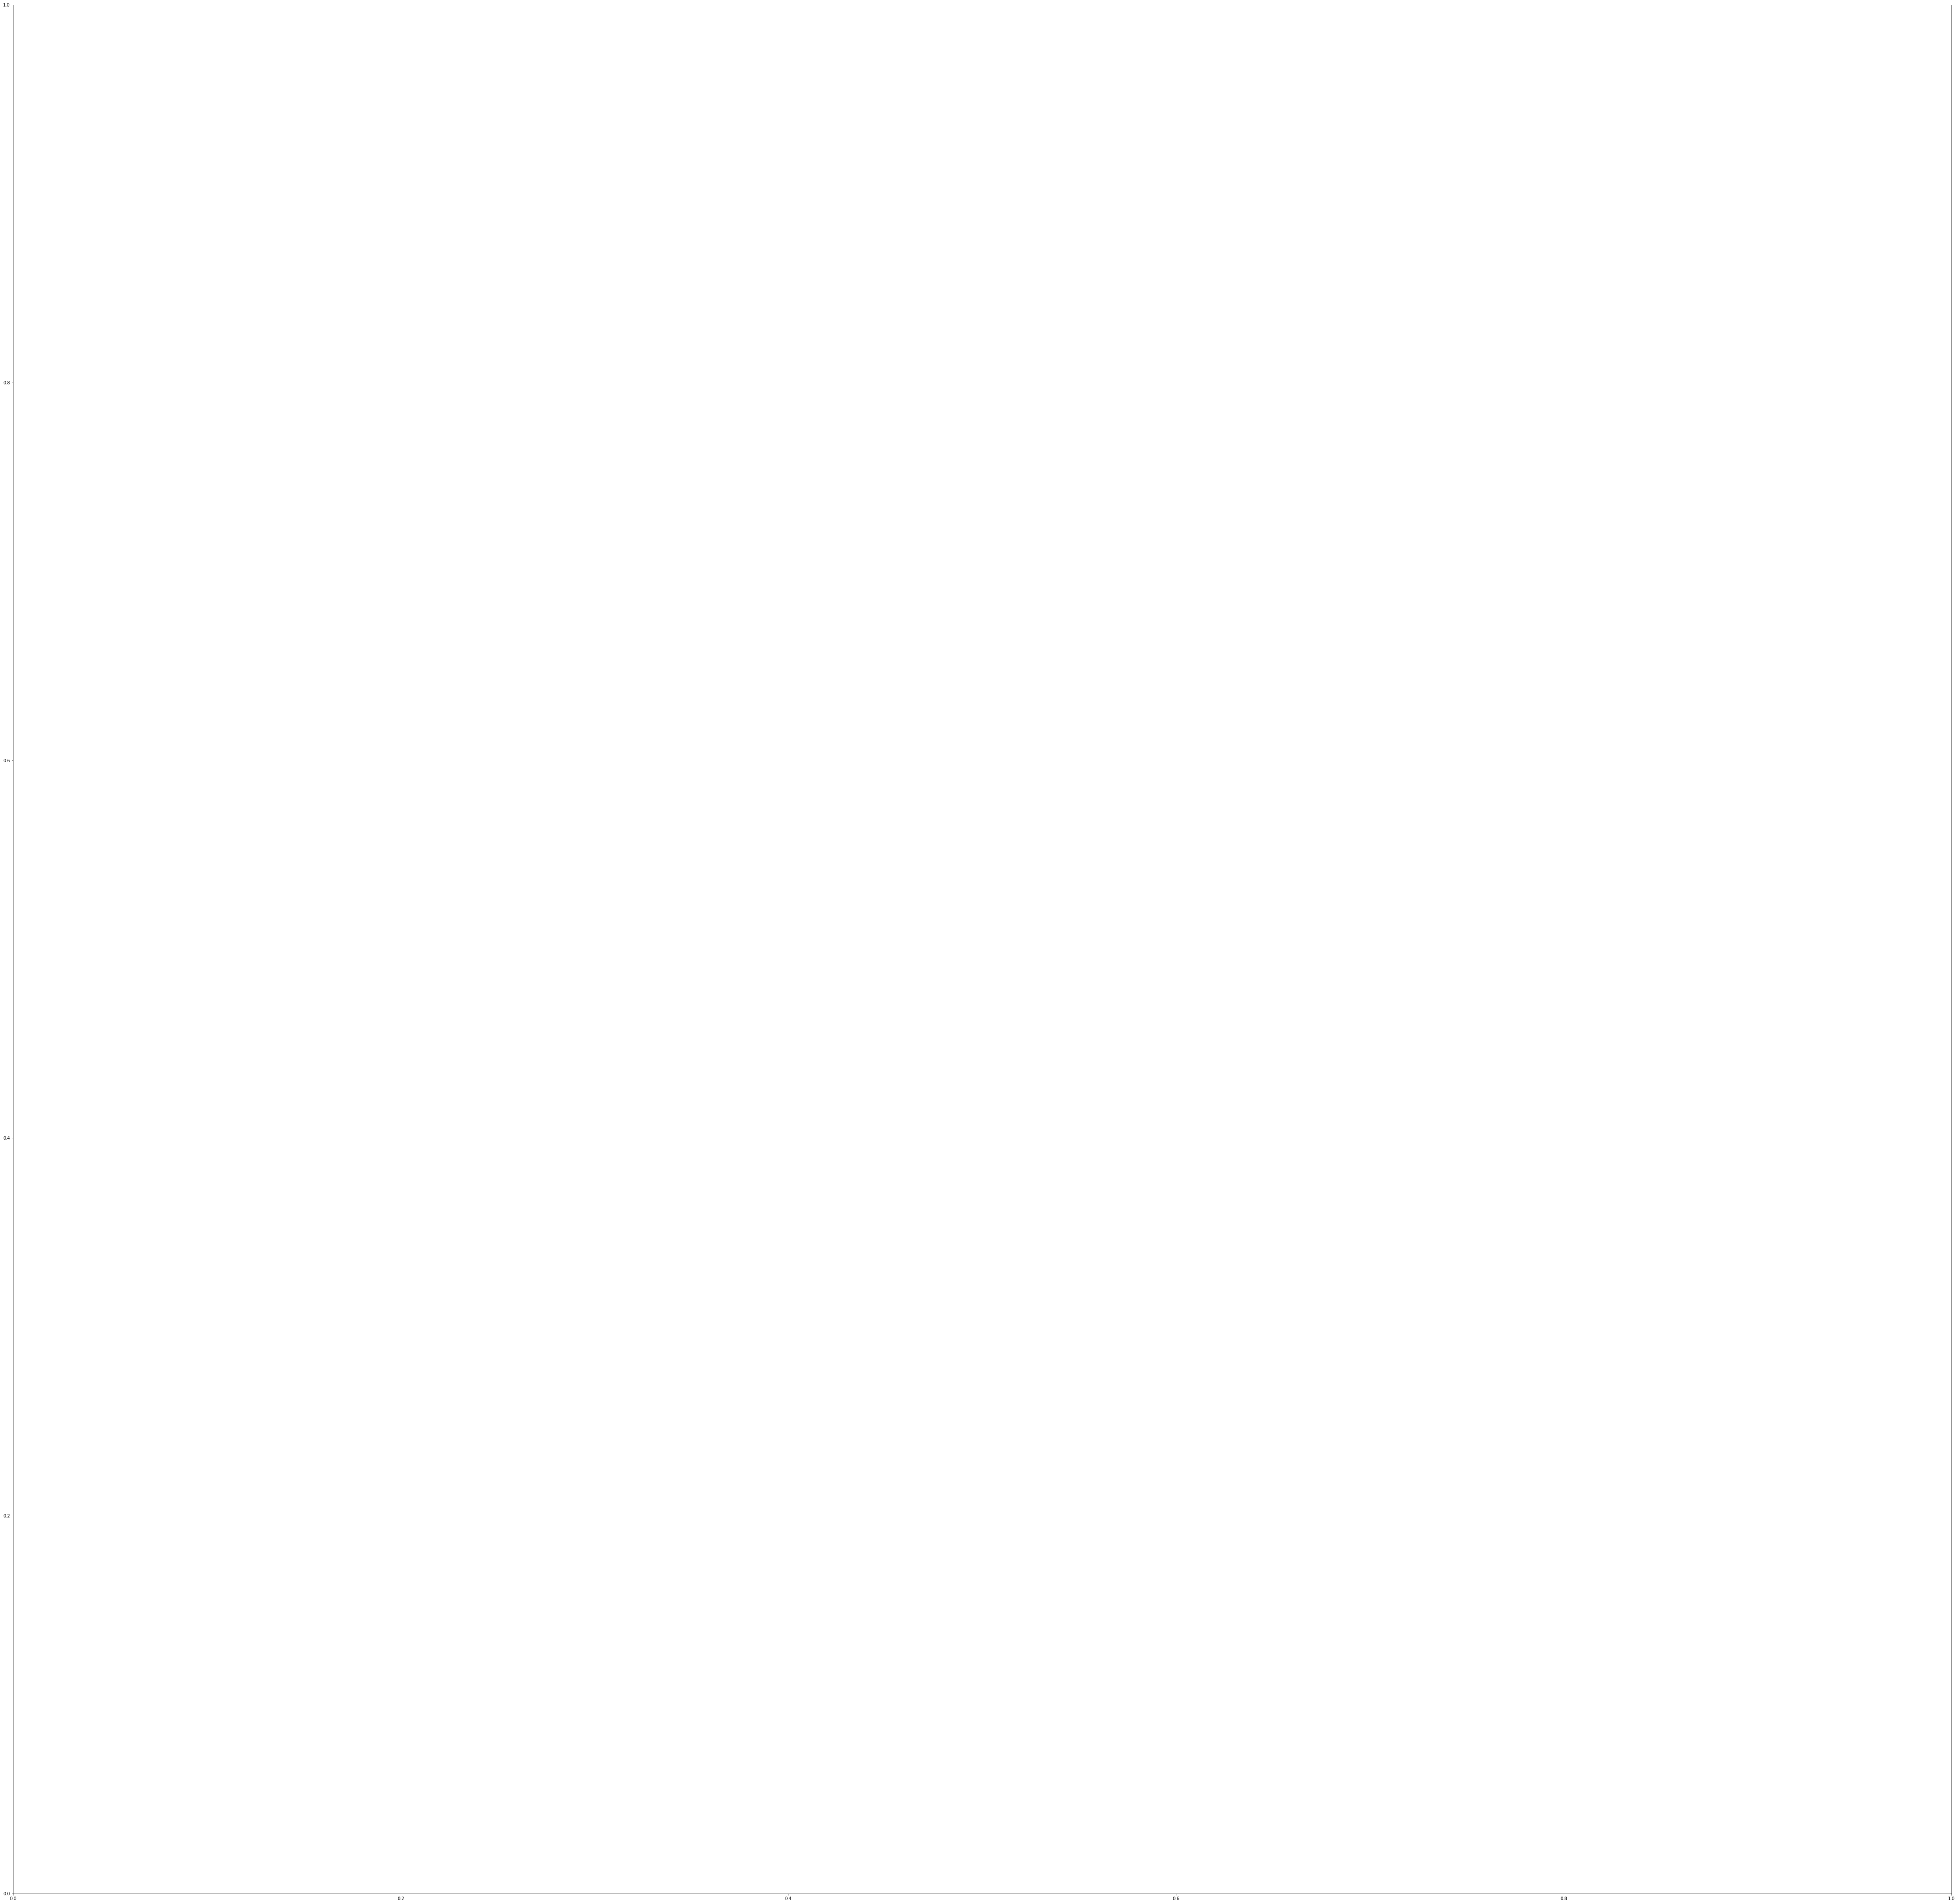

In [5]:
# pickle.dump( myblobs, open( "blobs.p", "wb" ) )
fig, ax = plt.subplots(1, 1, figsize=(80, 80), sharex=True, sharey=True)

plots = []

for pic,blobs_log in enumerate(myblobs):
    starblobs = blobs_log[np.where(blobs_log[:,2] <= 4)]
    if pic % 10 == 0:
        blobx = starblobs[:, 1] / 2172 - 0.5
        bloby = (1411 - starblobs[:, 0])/ 1411 - 0.5 #*1411/2172
        blobx,bloby = fish2cylindrical(blobx, bloby, 0.8337693, 1.8)
        bstring = [str(x) for x in range(len(blobx))]
        plots.append(
            go.Scatter(x=blobx, y=bloby, mode='markers', text=bstring, name=f"{pic}")
        )
layout = go.Layout(
    height = 800,
    width = 800
)



for cnt in range(1):
    t = ts.utc(timestamp.year, 
               timestamp.month, 
               timestamp.day, 
               timestamp.hour,
               timestamp.minute+cnt,
               timestamp.second)
#     print(t)
#     astrometric = boston.at(t).observe(bright_stars)
    apparent = cos.at(t).observe(bright_stars).apparent()
#     ra, dec, distance = apparent.radec('date')
    alt,az,distance = apparent.altaz()
    az_deg = np.pi*np.array(az.degrees) / 180
#     ax.scatter(az_deg, 90 - alt.degrees, 50*df['magnitude'], 'k')
    hips = df.index
    rad = 90 - alt.degrees
    idxs = np.where(rad < 90)
    mag = np.array(10*(8-df['magnitude']))
    x = (rad[idxs]*np.cos(az_deg[idxs])/180)
    y = (rad[idxs]*np.sin(az_deg[idxs])/180)
    hipvals = hips[idxs]
    plots.append(
        go.Scatter(x=x, y=y, mode='markers', name="ss")
    )
    
fig = go.Figure(data=plots, layout=layout)
iplot(fig)
#     ax.scatter(x, y,mag[idxs]*10)
#     print(np.min(x),np.max(x),np.min(y),np.max(y))
    
#     if cnt == 0:
#         for idx,hip in enumerate(hipvals):
#             if hip in stardict:
#                 ax.annotate(stardict[hip], (x[idx], y[idx]))

# plt.show()